In [1]:
from miditoolkit.midi.parser import MidiFile
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
from deepmusic import MusicRepr, Constants

## constants

In [3]:
const = Constants(
    unit=4,
    min_tempo=40,
    max_tempo=200,
    num_tempo_bins=20, 
    num_velocity_bins=20
)
const

Constants(unit=4, tick_resol=120, min_tempo=40, max_tempo=200, num_tempo_bins=20, num_velocity_bins=20)

## midi representation

In [16]:
seq = MusicRepr.from_file(
    'assets/test.mid', 
    unit=4,
    min_tempo=40,
    max_tempo=200,
    num_tempo_bins=20, 
    num_velocity_bins=20
)

# seq = MusicRepr.from_file('assets/test.mid', const=const)
seq

MusicRepr(
 num_events=4307,
 const=Constants(unit=4, tick_resol=120, min_tempo=40, max_tempo=200, num_tempo_bins=20, num_velocity_bins=20)
)

In [17]:
seq.const == const

True

### splitting bars

In [10]:
seq.get_bar_count()

76

In [24]:
bars = seq.get_bars()
len(bars)

76

## concatenating bars

In [12]:
seq2 = MusicRepr.concatenate(bars[:2])
seq2.get_bar_count()

2

## Slicing

### bar index

In [13]:
seq2 = seq.slice_by_bar(1,2)
print(seq2.events == bars[1].events, seq2 == bars[1])

True True


### beat index

In [14]:
seq2 = seq.slice_by_beat(12, 16)
print(seq2.events == bars[3].events, seq2 == bars[3])

True True


### event index

In [15]:
seq2 = seq.slice_by_index(0,10)
seq2[:]

[Bar(position=0, tempo=124),
 Beat(position=9, tempo=98),
 Bar(position=0),
 Beat(position=4),
 Note(inst_family=piano, pitch=64, duration=1, velocity=107),
 Beat(position=5),
 Note(inst_family=piano, pitch=65, duration=1, velocity=87),
 Beat(position=7),
 Note(inst_family=piano, pitch=67, duration=3, velocity=87),
 Beat(position=11)]

## separating different instrument tracks

In [42]:
tracks = seq.separate_tracks()
list(tracks.keys()), seq.get_instruments()

(['bass', 'ensemble', 'drums', 'piano', 'guitar'],
 ['bass', 'ensemble', 'drums', 'piano', 'guitar'])

In [43]:
for inst in tracks:
    print(tracks[inst].get_bar_count())

76
76
76
76
76


In [45]:
tracks['piano'][:10]

[Bar(position=0, tempo=124),
 Beat(position=9, tempo=98),
 Bar(position=0),
 Beat(position=4),
 Note(inst_family=piano, pitch=64, duration=1, velocity=107),
 Beat(position=5),
 Note(inst_family=piano, pitch=65, duration=1, velocity=87),
 Beat(position=7),
 Note(inst_family=piano, pitch=67, duration=3, velocity=87),
 Beat(position=11)]

### remove instruments

In [19]:
seq_t = seq.remove_instruments(instruments_to_remove=['drums'])
seq_t.get_instruments()

['bass', 'guitar', 'piano', 'ensemble']

### keep instruments

In [20]:
seq_t = seq.keep_instruments(instruments_to_keep=['drums'])
seq_t.get_instruments()

['drums']

## exporting

### pianoroll

(128, 1216)


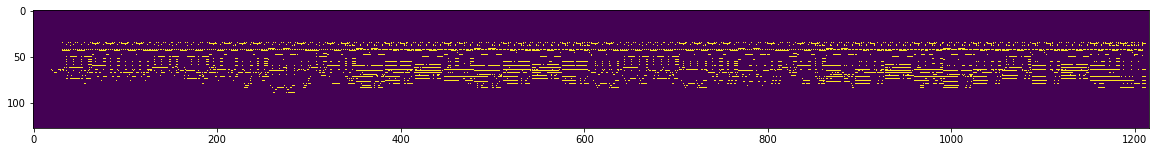

In [55]:
pianoroll = seq.to_pianoroll(separate_tracks=False, binarize=True, add_tempo_chord=False)
print(pianoroll.shape)
plt.figure(figsize=(20,10))
plt.imshow(pianoroll)
plt.show()

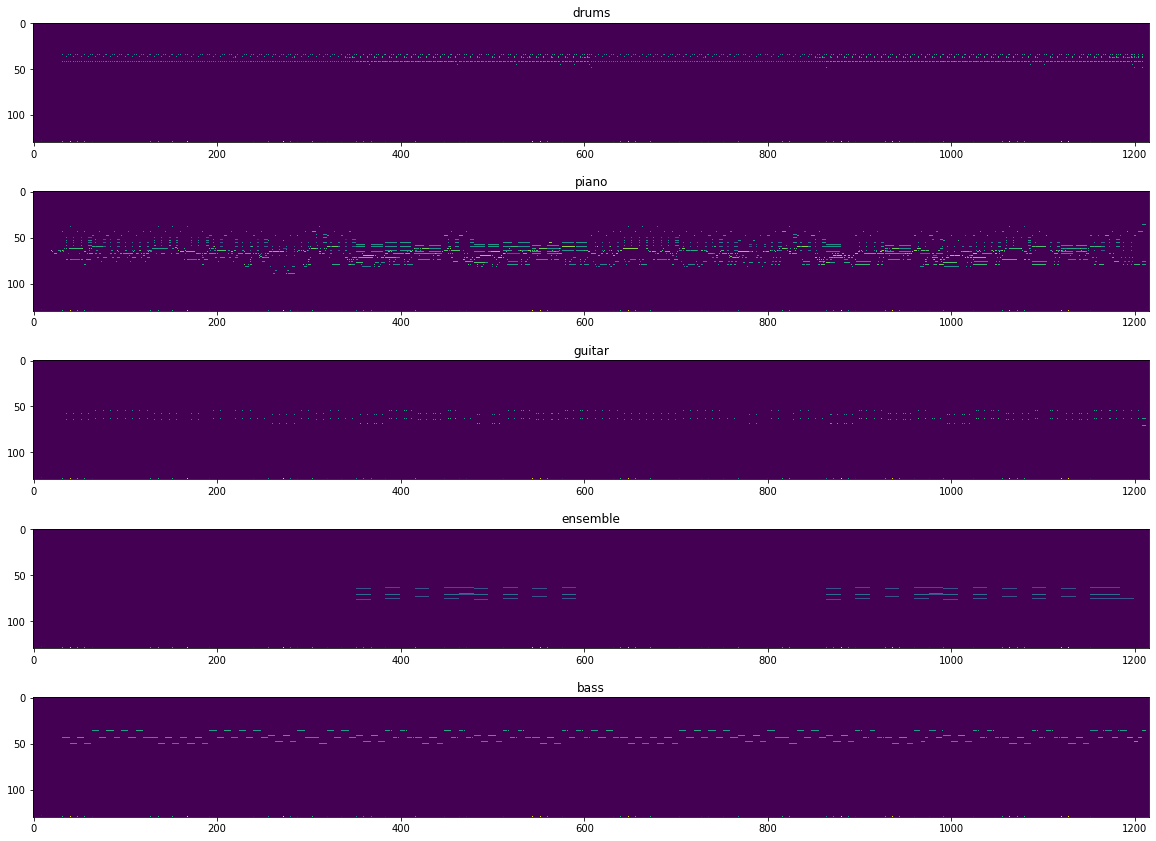

In [6]:
pianorolls = seq.to_pianoroll(separate_tracks=True, add_tempo_chord=True, binarize=False)
plt.figure(figsize=(20, len(pianorolls)*3))
for i, inst in enumerate(pianorolls):
    plt.subplot(len(pianorolls), 1, i+1)
    plt.title(inst)
    plt.imshow(pianorolls[inst])
plt.show()

### midi

In [23]:
midi = seq.to_midi('examples/assets/rec_test.mid')
midi

ticks per beat: 120
max tick: 36390
tempo changes: 2
time sig: 1
key sig: 0
markers: 70
lyrics: False
instruments: 5

### remi

In [18]:
remi = seq.to_remi(ret='token')
remi[:10]

['Bar',
 'BeatTempo_124',
 'BeatPosition_9',
 'BeatTempo_98',
 'Bar',
 'BeatPosition_4',
 'NoteInstFamily_piano',
 'NotePitch_64',
 'NoteDuration_1',
 'NoteVelocity_107']

In [19]:
seq.to_remi(ret='event')[:10]

[Event(type=Bar),
 Event(type=BeatTempo, value=124),
 Event(type=BeatPosition, value=9),
 Event(type=BeatTempo, value=98),
 Event(type=Bar),
 Event(type=BeatPosition, value=4),
 Event(type=NoteInstFamily, value=piano),
 Event(type=NotePitch, value=64),
 Event(type=NoteDuration, value=1),
 Event(type=NoteVelocity, value=107)]

In [20]:
seq.to_remi(ret='index', add_eos=True)[:10]

[0, 27, 10, 24, 0, 5, 169, 250, 314, 346]

### compound word

In [21]:
cp = seq.to_cp(add_eos=True)
cp.shape, len(seq)

((4308, 8), 4307)

In [22]:
cp[:10]

array([[ 0,  0, 11,  0,  0,  0,  0,  0],
       [ 0,  9,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 64,  0, 16],
       [ 0,  5,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 65,  0, 13],
       [ 0,  7,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 67,  2, 13],
       [ 0, 11,  0,  0,  0,  0,  0,  0]])

In [25]:
bars[0].to_cp()

array([[ 0,  0, 11,  0,  0,  0,  0,  0],
       [ 0,  9,  8,  0,  0,  0,  0,  0]])

## Importing

### from pianoroll

In [27]:
pianorolls = seq.to_pianoroll(separate_tracks=True, add_tempo_chord=True, binarize=False)
pianoroll_tracks = dict([
    (inst, MusicRepr.from_single_pianoroll(pianorolls[inst], inst=inst, const=const)) 
    for inst in pianorolls
])

seq_t = MusicRepr.merge_tracks(pianoroll_tracks)

In [29]:
seq_t[:20]

[Bar(position=0, tempo=124),
 Beat(position=9, tempo=98),
 Bar(position=0),
 Beat(position=4),
 Note(inst_family=piano, pitch=64, duration=1, velocity=107),
 Beat(position=5),
 Note(inst_family=piano, pitch=65, duration=1, velocity=87),
 Beat(position=7),
 Note(inst_family=piano, pitch=67, duration=3, velocity=87),
 Beat(position=11),
 Note(inst_family=piano, pitch=64, duration=3, velocity=73),
 Beat(position=13),
 Note(inst_family=piano, pitch=65, duration=1, velocity=80),
 Beat(position=14),
 Note(inst_family=piano, pitch=64, duration=1, velocity=93),
 Bar(position=0, chord=G_M7),
 Note(inst_family=drums, pitch=35, duration=1, velocity=67),
 Note(inst_family=drums, pitch=42, duration=1, velocity=67),
 Note(inst_family=bass, pitch=43, duration=8, velocity=73),
 Note(inst_family=piano, pitch=43, duration=1, velocity=67)]

In [30]:
seq_t.get_bar_count() == seq.get_bar_count()

True

### from cp

In [31]:
seq_t = MusicRepr.from_cp(cp, const=seq.const)
seq_t.events == seq.events, seq == seq_t

(True, True)

### from remi

In [32]:
seq_t = MusicRepr.from_string(' '.join(remi), const=seq.const)
seq_t.events == seq.events, seq == seq_t

(True, True)

## merging tracks

In [33]:
tracks = seq.separate_tracks()

In [34]:
seq_t = MusicRepr.merge_tracks(tracks)
seq == seq_t

True